In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

from scipy.stats import norm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb

In [2]:
df_ori = pd.read_csv("data/jenny/final_preprocessed.csv")
df_ori["date"] = pd.to_datetime(df_ori["date"], format='%Y-%m-%d')
# print(df.dtypes)
df_ori.head(3)

,date,month,year,Temp,Flow,Level,count,october_Flow,november_Flow,december_Temp,...,rolling_Level_mean_5,rolling_Temp_std_15,rolling_Temp_std_10,rolling_Temp_std_5,rolling_Flow_std_15,rolling_Flow_std_10,rolling_Flow_std_5,rolling_Level_std_15,rolling_Level_std_10,rolling_Level_std_5
0,2013-09-02,9,2013,19.127273,0.8755,0.5480,0.0,7.679129,28.3825,3.965188,...,0.8237,2.160008,1.950006,1.571429,2.041962,1.416962,0.74561,0.060489,0.042766,0.024903
1,2013-09-03,9,2013,18.045833,0.7905,0.5405,0.0,7.679129,28.3825,3.965188,...,0.8237,2.160008,1.950006,1.571429,2.041962,1.416962,0.74561,0.060489,0.042766,0.024903
2,2013-09-04,9,2013,17.062500,0.7490,0.5365,0.0,7.679129,28.3825,3.965188,...,0.8237,2.160008,1.950006,1.571429,2.041962,1.416962,0.74561,0.060489,0.042766,0.024903


In [3]:
include_months = [4,5,6,7,8,9]
df = df_ori[df_ori["month"].isin(include_months)]
df = df.reset_index()

print(df.shape)

(1859, 33)


RMSE: 196.599389600031


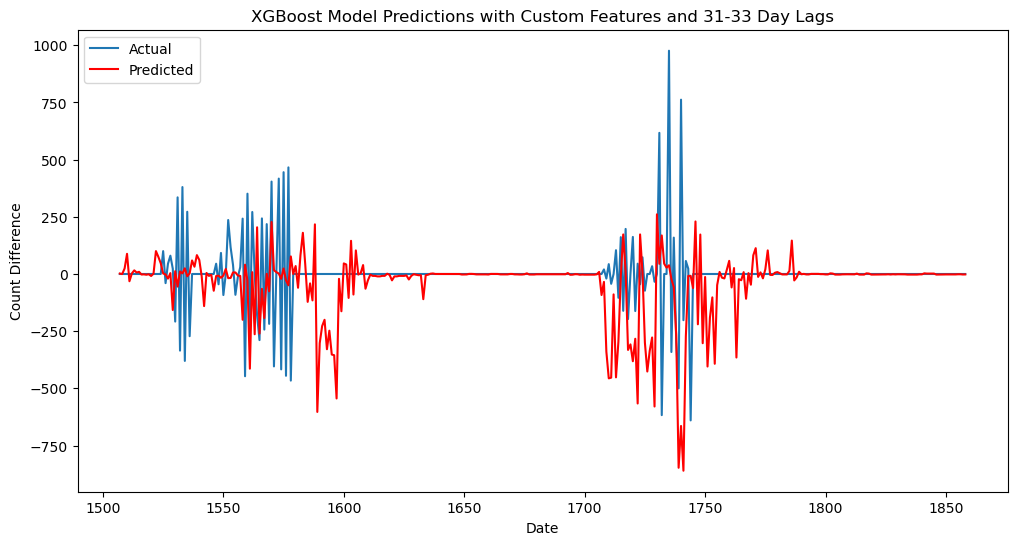

In [8]:
df['count_diff'] = df['count'].diff().dropna()

# Feature Engineering: Create lag features with a 30-day skip
df['lag_31'] = df['count_diff'].shift(31)
df['lag_32'] = df['count_diff'].shift(32)
df['lag_33'] = df['count_diff'].shift(33)

df['flow_31'] = df['Flow'].shift(31)
df['flow_32'] = df['Flow'].shift(32)
df['flow_33'] = df['Flow'].shift(33)

df['temperature_31'] = df['Temp'].shift(31)
df['temperature_32'] = df['Temp'].shift(32)
df['temperature_33'] = df['Temp'].shift(33)

# Drop NA values after feature engineering
df.dropna(inplace=True)

# Define the features to use
use_for_feats = ['month', 
                 'october_Flow',
                 'november_Flow',
                 'december_Temp',
                 'january_Temp',
                 'feburary_Temp',
                 'rolling_Temp_mean_5',
                 'rolling_Flow_mean_5',
                 'lag_31', 'lag_32', 'lag_33', 'flow_31', 'flow_32', 'flow_33', 'temperature_31', 'temperature_32', 'temperature_33']

# Define predictors and target variable
X = df[use_for_feats]
y = df['count_diff']

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', color='red')
plt.legend(loc='upper left')
plt.title('XGBoost Model Predictions with Custom Features and 31-33 Day Lags')
plt.xlabel('Date')
plt.ylabel('Count Difference')
plt.show()

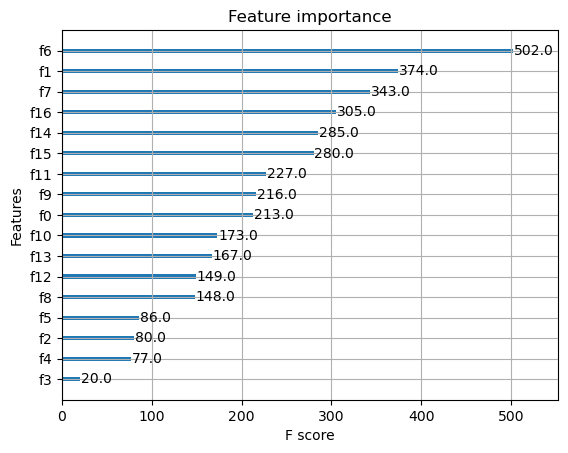

In [5]:
xgb.plot_importance(model)
plt.show()

In [6]:
y_pred

array([ 5.25027215e-01, -1.87663288e+01, -2.23248768e+00, -2.10920453e+00,
       -2.10920453e+00, -3.56931472e+00, -3.56931472e+00, -3.56931472e+00,
       -2.95616698e+00,  1.03851974e+00, -3.15869498e+00, -3.56931472e+00,
       -2.10920453e+00, -1.18354309e+00, -5.21884024e-01, -5.39145708e+00,
        5.87050095e+01, -2.00297661e+01,  8.30612564e+00, -1.84602547e+01,
        5.76724768e-01,  2.95673442e+00, -3.13919365e-01, -1.05581358e-01,
       -2.12918258e+00, -2.10920453e+00, -8.03573990e+00,  1.53572340e+01,
       -5.31744528e+00,  4.73453808e+00,  1.98002899e+02, -6.72152863e+01,
        1.29825974e+01, -2.00885868e+01,  6.29309464e+00, -1.58217363e+01,
       -5.99529445e-01, -3.72289047e+01,  2.07277794e+01,  2.65447903e+00,
        6.15920525e+01, -5.51304340e+00,  8.57269363e+01,  9.53574600e+01,
        2.53550959e+00,  1.77504791e+02,  1.02886337e+02,  9.72883606e+00,
       -3.62557587e+02,  2.51133404e+01, -1.37908936e+01, -1.68725796e+01,
       -2.70808334e+01, -